In [1]:
!nvidia-smi

Wed Jan  1 12:49:35 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8             11W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
!pip install -U torch # requires torch 2.1.1+ (for efficient sdpa implementation)
!pip install PyMuPDF # for reading PDFs with Python
!pip install tqdm # for progress bars
!pip install sentence-transformers # for embedding models
!pip install accelerate # for quantization model loading
!pip install bitsandbytes # for quantizing models (less storage space)
!pip install flash-attn --no-build-isolation # for faster attention mechanism = faster LLM inference

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/906.4 MB 1.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 96.1 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 9.0 MB/s eta 0:00:000:00:0100:01
   ━━━

In [3]:
import fitz
from tqdm.auto import tqdm

def text_formatter(text: str) -> str:
    """Performs minor formatting on text."""
    cleaned_text = text.replace("\n", " ").strip()

    return cleaned_text

# Open PDF and get lines/pages
def open_and_read_pdf(pdf_path: str) -> list[dict]:
    """
    Opens a PDF file, reads its text content page by page, and collects statistics.

    Parameters:
        pdf_path (str): The file path to the PDF document to be opened and read.

    Returns:
        list[dict]: A list of dictionaries, each containing the page number
        (adjusted), character count, word count, sentence count, token count, and the extracted text
        for each page.
    """
    doc = fitz.open(pdf_path)# open a document
    pages_and_texts = []
    for page_number, page in tqdm(enumerate(doc)):# iterate the document pages
        text = page.get_text()  # get plain text encoded as UTF-8
        text = text_formatter(text)
        pages_and_texts.append({"page_number": page_number - 41,
                                "page_char_count": len(text),
                                "page_word_count": len(text.split(" ")),
                                "page_sentence_count_raw": len(text.split(". ")),
                                "page_token_count": len(text) / 4,
                                "text": text})
    return pages_and_texts

pdf_path = "/kaggle/input/human-nutrition-text-pdf/human-nutrition-text.pdf"
pages_and_texts = open_and_read_pdf(pdf_path=pdf_path)
pages_and_texts[:2]

0it [00:00, ?it/s]

[{'page_number': -41,
  'page_char_count': 29,
  'page_word_count': 4,
  'page_sentence_count_raw': 1,
  'page_token_count': 7.25,
  'text': 'Human Nutrition: 2020 Edition'},
 {'page_number': -40,
  'page_char_count': 0,
  'page_word_count': 1,
  'page_sentence_count_raw': 1,
  'page_token_count': 0.0,
  'text': ''}]

In [4]:
import random

random.sample(pages_and_texts, k=3)

[{'page_number': 387,
  'page_char_count': 1328,
  'page_word_count': 248,
  'page_sentence_count_raw': 11,
  'page_token_count': 332.0,
  'text': 'PDB 1o9x EBI  by Jawahar  Swaminatha n and MSD  staff at the  European  Bioinformati cs Institute /  Public  Domain The  butterfly-sha ped protein,  albumin, has  many  functions in  the body  including  maintaining  fluid and  acid-base  balance and  transporting  molecules.  If too much water in the blood suddenly moves into a tissue, the  results are swelling and, potentially, cell death. Water always flows  from an area of high concentration to one of a low concentration. As  a result, water moves toward areas that have higher concentrations  of other solutes, such as proteins and glucose. To keep the water  evenly distributed between blood and cells, proteins continuously  circulate at high concentrations in the blood. The most abundant  protein in blood is the butterfly-shaped protein known as albumin.  Albumin’s presence in the blood

In [5]:
import pandas as pd

df = pd.DataFrame(pages_and_texts)
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,-41,29,4,1,7.25,Human Nutrition: 2020 Edition
1,-40,0,1,1,0.00,
2,-39,320,54,1,80.00,Human Nutrition: 2020 Edition UNIVERSITY OF ...
3,-38,212,32,1,53.00,Human Nutrition: 2020 Edition by University of...
4,-37,797,145,2,199.25,Contents Preface University of Hawai‘i at Mā...


In [6]:
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,198.30,9.97,287.00
std,348.86,560.38,95.76,6.19,140.10
min,-41.00,0.00,1.00,1.00,0.00
25%,260.75,762.00,134.00,4.00,190.50
50%,562.50,1231.50,214.50,10.00,307.88
75%,864.25,1603.50,271.00,14.00,400.88
max,1166.00,2308.00,429.00,32.00,577.00


In [7]:
from spacy.lang.en import English
nlp = English()
nlp.add_pipe("sentencizer")
doc = nlp("This is a sentence. This another sentence.")
assert len(list(doc.sents)) == 2
list(doc.sents)

[This is a sentence., This another sentence.]

In [8]:
for item in tqdm(pages_and_texts):
    item["sentences"] = list(nlp(item["text"]).sents)
    item["sentences"] = [str(sentence) for sentence in item["sentences"]]
    item["page_sentence_count_spacy"] = len(item["sentences"])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [9]:
random.sample(pages_and_texts, k=1)

[{'page_number': 1078,
  'page_char_count': 1994,
  'page_word_count': 344,
  'page_sentence_count_raw': 17,
  'page_token_count': 498.5,
  'text': 'eat smaller meals, stop smoking, and remain upright for at least  three hours after a meal. People with GERD may not take in the  nutrients they need because of the pain and discomfort associated  with eating. As a result, GERD can be caused by an unbalanced diet  and its symptoms can lead to a worsening of nutrient inadequacy, a  vicious cycle that further compromises health. Some evidence from  scientific studies indicates that medications used to treat GERD  may accentuate certain nutrient deficiencies, namely zinc and  magnesium. When these treatment approaches do not work surgery  is an option. The most common surgery involves reinforcing the  sphincter that serves as a barrier between the stomach and  esophagus.  Irritable Bowel Syndrome  Irritable bowel syndrome (IBS) is characterized by muscle spasms in  the colon that result in ab

In [10]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,198.30,9.97,287.00,10.32
std,348.86,560.38,95.76,6.19,140.10,6.30
min,-41.00,0.00,1.00,1.00,0.00,0.00
25%,260.75,762.00,134.00,4.00,190.50,5.00
50%,562.50,1231.50,214.50,10.00,307.88,10.00
75%,864.25,1603.50,271.00,14.00,400.88,15.00
max,1166.00,2308.00,429.00,32.00,577.00,28.00


In [11]:
num_sentence_chunk_size = 10 

def split_list(input_list: list, 
               slice_size: int) -> list[list[str]]:
    """
    Splits the input_list into sublists of size slice_size (or as close as possible).

    For example, a list of 17 sentences would be split into two lists of [[10], [7]]
    """
    return [input_list[i:i + slice_size] for i in range(0, len(input_list), slice_size)]

for item in tqdm(pages_and_texts):
    item["sentence_chunks"] = split_list(input_list=item["sentences"],
                                         slice_size=num_sentence_chunk_size)
    item["num_chunks"] = len(item["sentence_chunks"])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [12]:
random.sample(pages_and_texts, k=1)

[{'page_number': 411,
  'page_char_count': 1810,
  'page_word_count': 332,
  'page_sentence_count_raw': 14,
  'page_token_count': 452.5,
  'text': 'your exact recommended protein intake per day based on your  weight by using the following equation:  (Weight in lbs. ÷ 2.2 lb/kg) × 0.8 g/kg  Note that if a person is overweight, the amount of dietary protein  recommended can be overestimated.  The IOM used data from multiple studies that determined  nitrogen balance in people of different age groups to calculate the  RDA for protein. A person is said to be in nitrogen balance when the  nitrogen input equals the amount of nitrogen used and excreted. A  person is in negative nitrogen balance when the amount of excreted  nitrogen is greater than that consumed, meaning that the body is  breaking down more protein to meet its demands. This state of  imbalance can occur in people who have certain diseases, such  as cancer or muscular dystrophy. Someone who has a low-protein  diet may also be in

In [13]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,198.30,9.97,287.00,10.32,1.53
std,348.86,560.38,95.76,6.19,140.10,6.30,0.64
min,-41.00,0.00,1.00,1.00,0.00,0.00,0.00
25%,260.75,762.00,134.00,4.00,190.50,5.00,1.00
50%,562.50,1231.50,214.50,10.00,307.88,10.00,1.00
75%,864.25,1603.50,271.00,14.00,400.88,15.00,2.00
max,1166.00,2308.00,429.00,32.00,577.00,28.00,3.00


In [14]:
import re

pages_and_chunks = []
for item in tqdm(pages_and_texts):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict["page_number"] = item["page_number"]
        
        joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk)
        chunk_dict["sentence_chunk"] = joined_sentence_chunk

        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4 # 1 token = ~4 characters
        
        pages_and_chunks.append(chunk_dict)

len(pages_and_chunks)

  0%|          | 0/1208 [00:00<?, ?it/s]

1843

In [15]:
random.sample(pages_and_chunks, k=1)

[{'page_number': 97,
  'sentence_chunk': 'juice every day for twelve weeks had improved learning and memorization skills in comparison to other subjects given a placebo drink.2 However, it is important to keep in mind that this was a short- term study. Blueberries also are high in manganese, and high intake of manganese over time is known to have neurotoxic effects. Variety in the diet is perhaps the most important concept in applied nutrition. More clinical trials are evaluating the effects of blueberries and other foods that benefit the brain and preserve its function as we age. Learning Activities Technology Note: The second edition of the Human Nutrition Open Educational Resource (OER) textbook features interactive learning activities.\xa0 These activities are available in the web-based textbook and not available in the downloadable versions (EPUB, Digital PDF, Print_PDF, or Open Document). Learning activities may be used across various mobile devices, however, for the best user ex

In [16]:
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,1843.00,1843.00,1843.00,1843.00
mean,583.38,734.44,112.33,183.61
std,347.79,447.54,71.22,111.89
min,-41.00,12.00,3.00,3.00
25%,280.50,315.00,44.00,78.75
50%,586.00,746.00,114.00,186.50
75%,890.00,1118.50,173.00,279.62
max,1166.00,1831.00,297.00,457.75


In [17]:
min_token_length = 30
for row in df[df["chunk_token_count"] <= min_token_length].sample(5).iterrows():
    print(f'Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}')

Chunk token count: 24.25 | Text: These activities are available in the web-based textbook and not available in the Magnesium | 643
Chunk token count: 11.75 | Text: Accessed April 15, 2018. 1046 | Comparing Diets
Chunk token count: 16.5 | Text: PART X CHAPTER 10. MAJOR MINERALS Chapter 10. Major Minerals | 607
Chunk token count: 9.75 | Text: Older Adulthood: The Golden Years | 925
Chunk token count: 20.5 | Text: PART III CHAPTER 3. WATER AND ELECTROLYTES Chapter 3. Water and Electrolytes | 143


In [18]:
pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_len[:2]

[{'page_number': -39,
  'sentence_chunk': 'Human Nutrition: 2020 Edition UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM ALAN TITCHENAL, SKYLAR HARA, NOEMI ARCEO CAACBAY, WILLIAM MEINKE-LAU, YA-YUN YANG, MARIE KAINOA FIALKOWSKI REVILLA, JENNIFER DRAPER, GEMADY LANGFELDER, CHERYL GIBBY, CHYNA NICOLE CHUN, AND ALLISON CALABRESE',
  'chunk_char_count': 308,
  'chunk_word_count': 42,
  'chunk_token_count': 77.0},
 {'page_number': -38,
  'sentence_chunk': 'Human Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science and Human Nutrition Program is licensed under a Creative Commons Attribution 4.0 International License, except where otherwise noted.',
  'chunk_char_count': 210,
  'chunk_word_count': 30,
  'chunk_token_count': 52.5}]

In [19]:
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2", 
                                      device="cpu")

sentences = [
    "The Sentences Transformers library provides an easy and open-source way to create embeddings.",
    "Sentences can be embedded one by one or as a list of strings.",
    "Embeddings are one of the most powerful concepts in machine learning!",
    "Learn to use embeddings well and you'll be well on your way to being an AI engineer."
]

embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences, embeddings))

for sentence, embedding in embeddings_dict.items():
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print("")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Sentence: The Sentences Transformers library provides an easy and open-source way to create embeddings.
Embedding: [-2.07980759e-02  3.03164292e-02 -2.01217867e-02  6.86483979e-02
 -2.55255848e-02 -8.47689435e-03 -2.07126111e-04 -6.32378012e-02
  2.81605609e-02 -3.33353691e-02  3.02634481e-02  5.30720316e-02
 -5.03526479e-02  2.62287874e-02  3.33313942e-02 -4.51578684e-02
  3.63043807e-02 -1.37114851e-03 -1.20170889e-02  1.14947148e-02
  5.04510552e-02  4.70857285e-02  2.11912375e-02  5.14607690e-02
 -2.03746166e-02 -3.58889550e-02 -6.67856308e-04 -2.94393171e-02
  4.95859273e-02 -1.05639696e-02 -1.52013144e-02 -1.31752773e-03
  4.48196977e-02  1.56022888e-02  8.60379771e-07 -1.21391483e-03
 -2.37978119e-02 -9.09392838e-04  7.34488200e-03 -2.53933039e-03
  5.23369834e-02 -4.68043871e-02  1.66214798e-02  4.71579172e-02
 -4.15599346e-02  9.01933818e-04  3.60278450e-02  3.42214480e-02
  9.68227163e-02  5.94828203e-02 -1.64984651e-02 -3.51249948e-02
  5.92517015e-03 -7.07975938e-04 -2.4103

In [20]:
single_sentence = "Yo! How cool are embeddings?"
single_embedding = embedding_model.encode(single_sentence)
print(f"Sentence: {single_sentence}")
print(f"Embedding:\n{single_embedding}")
print(f"Embedding size: {single_embedding.shape}")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Sentence: Yo! How cool are embeddings?
Embedding:
[-1.97447427e-02 -4.51086881e-03 -4.98485053e-03  6.55445009e-02
 -9.87679232e-03  2.72835400e-02  3.66426297e-02 -3.30218766e-03
  8.50079488e-03  8.24953429e-03 -2.28496902e-02  4.02430221e-02
 -5.75200692e-02  6.33693114e-02  4.43207026e-02 -4.49507199e-02
  1.25284074e-02 -2.52012592e-02 -3.55292559e-02  1.29559208e-02
  8.67017172e-03 -1.92917418e-02  3.55633581e-03  1.89505871e-02
 -1.47128394e-02 -9.39850323e-03  7.64166377e-03  9.62190889e-03
 -5.98926842e-03 -3.90170179e-02 -5.47824502e-02 -5.67451864e-03
  1.11644585e-02  4.08067852e-02  1.76319122e-06  9.15295724e-03
 -8.77268612e-03  2.39383057e-02 -2.32784506e-02  8.04999471e-02
  3.19177508e-02  5.12592029e-03 -1.47708794e-02 -1.62525047e-02
 -6.03212789e-02 -4.35689688e-02  4.51210849e-02 -1.79053862e-02
  2.63366923e-02 -3.47867236e-02 -8.89174361e-03 -5.47675230e-02
 -1.24372840e-02 -2.38606390e-02  8.33497047e-02  5.71242571e-02
  1.13328639e-02 -1.49595207e-02  9.2037

In [21]:
%%time
# Send the model to the GPU
embedding_model.to("cuda")

# Create embeddings one by one on the GPU
for item in tqdm(pages_and_chunks_over_min_token_len):
    item["embedding"] = embedding_model.encode(item["sentence_chunk"])

  0%|          | 0/1680 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 1min 20s, sys: 4.44 s, total: 1min 24s
Wall time: 55.3 s


In [22]:
# Save embeddings to file
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = "text_chunks_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

In [23]:
text_chunks_and_embedding_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embedding_df_load.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,[ 6.74242675e-02 9.02281404e-02 -5.09548886e-...
1,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50,[ 5.52156419e-02 5.92139773e-02 -1.66167244e-...
2,-37,Contents Preface University of Hawai‘i at Māno...,766,114,191.50,[ 2.79801842e-02 3.39813754e-02 -2.06426680e-...
3,-36,Lifestyles and Nutrition University of Hawai‘i...,941,142,235.25,[ 6.82566911e-02 3.81275006e-02 -8.46854132e-...
4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,[ 3.30264494e-02 -8.49763490e-03 9.57159605e-...


In [24]:
import random

import torch
import numpy as np 
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"

text_chunks_and_embedding_df = pd.read_csv("text_chunks_and_embeddings_df.csv")
text_chunks_and_embedding_df["embedding"] = text_chunks_and_embedding_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))
pages_and_chunks = text_chunks_and_embedding_df.to_dict(orient="records")
embeddings = torch.tensor(np.array(text_chunks_and_embedding_df["embedding"].tolist()), dtype=torch.float32).to(device)
embeddings.shape

torch.Size([1680, 768])

In [25]:
text_chunks_and_embedding_df.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,"[0.0674242675, 0.0902281404, -0.00509548886, -..."
1,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50,"[0.0552156419, 0.0592139773, -0.0166167244, -0..."
2,-37,Contents Preface University of Hawai‘i at Māno...,766,114,191.50,"[0.0279801842, 0.0339813754, -0.020642668, 0.0..."
3,-36,Lifestyles and Nutrition University of Hawai‘i...,941,142,235.25,"[0.0682566911, 0.0381275006, -0.00846854132, -..."
4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,"[0.0330264494, -0.0084976349, 0.00957159605, -..."


In [26]:
embeddings[0]

tensor([ 6.7424e-02,  9.0228e-02, -5.0955e-03, -3.1755e-02,  7.3908e-02,
         3.5198e-02, -1.9799e-02,  4.6769e-02,  5.3573e-02,  5.0123e-03,
         3.3393e-02, -1.6222e-03,  1.7608e-02,  3.6265e-02, -3.1668e-04,
        -1.0712e-02,  1.5426e-02,  2.6218e-02,  2.7765e-03,  3.6494e-02,
        -4.4411e-02,  1.8936e-02,  4.9012e-02,  1.6402e-02, -4.8578e-02,
         3.1829e-03,  2.7299e-02, -2.0476e-03, -1.2283e-02, -7.2805e-02,
         1.2045e-02,  1.0730e-02,  2.1000e-03, -8.1777e-02,  2.6783e-06,
        -1.8143e-02, -1.2080e-02,  2.4717e-02, -6.2747e-02,  7.3544e-02,
         2.2162e-02, -3.2877e-02, -1.8010e-02,  2.2295e-02,  5.6137e-02,
         1.7951e-03,  5.2593e-02, -3.3174e-03, -8.3387e-03, -1.0628e-02,
         2.3192e-03, -2.2393e-02, -1.5301e-02, -9.9306e-03,  4.6532e-02,
         3.5747e-02, -2.5476e-02,  2.6369e-02,  3.7491e-03, -3.8268e-02,
         2.5833e-02,  4.1287e-02,  2.5818e-02,  3.3297e-02, -2.5178e-02,
         4.5152e-02,  4.4907e-04, -9.9662e-02,  4.9

In [27]:
from sentence_transformers import util, SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2", 
                                      device=device)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [28]:
query = "macronutrients functions"
print(f"Query: {query}")

query_embedding = embedding_model.encode(query, convert_to_tensor=True)
from time import perf_counter as timer

start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")
top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product

Query: macronutrients functions


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Time take to get scores on 1680 embeddings: 0.02237 seconds.


torch.return_types.topk(
values=tensor([0.6926, 0.6738, 0.6646, 0.6536, 0.6473], device='cuda:0'),
indices=tensor([42, 47, 41, 51, 46], device='cuda:0'))

In [29]:
larger_embeddings = torch.randn(100*embeddings.shape[0], 768).to(device)
print(f"Embeddings shape: {larger_embeddings.shape}")

# Perform dot product across 168,000 embeddings
start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=larger_embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(larger_embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

Embeddings shape: torch.Size([168000, 768])
Time take to get scores on 168000 embeddings: 0.00079 seconds.


In [30]:
import textwrap

def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

In [31]:
print(f"Query: '{query}'\n")
print("Results:")
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score:.4f}")
    print("Text:")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
    print(f"Page number: {pages_and_chunks[idx]['page_number']}")
    print("\n")

Query: 'macronutrients functions'

Results:
Score: 0.6926
Text:
Macronutrients Nutrients that are needed in large amounts are called
macronutrients. There are three classes of macronutrients: carbohydrates,
lipids, and proteins. These can be metabolically processed into cellular energy.
The energy from macronutrients comes from their chemical bonds. This chemical
energy is converted into cellular energy that is then utilized to perform work,
allowing our bodies to conduct their basic functions. A unit of measurement of
food energy is the calorie. On nutrition food labels the amount given for
“calories” is actually equivalent to each calorie multiplied by one thousand. A
kilocalorie (one thousand calories, denoted with a small “c”) is synonymous with
the “Calorie” (with a capital “C”) on nutrition food labels. Water is also a
macronutrient in the sense that you require a large amount of it, but unlike the
other macronutrients, it does not yield calories. Carbohydrates Carbohydrates
are 

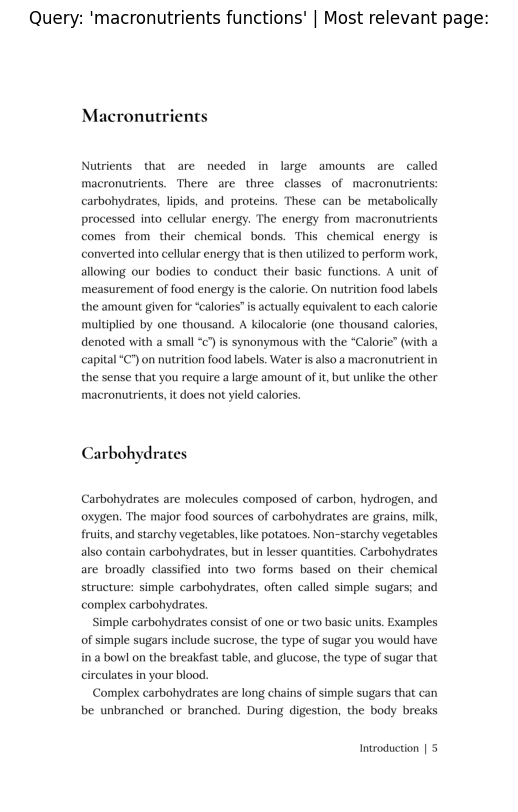

In [32]:
import fitz

pdf_path = "/kaggle/input/human-nutrition-text-pdf/human-nutrition-text.pdf"
doc = fitz.open(pdf_path)
page = doc.load_page(5 + 41) # number of page (our doc starts page numbers on page 41)
img = page.get_pixmap(dpi=300)
doc.close()

img_array = np.frombuffer(img.samples_mv, 
                          dtype=np.uint8).reshape((img.h, img.w, img.n))

import matplotlib.pyplot as plt
plt.figure(figsize=(13, 10))
plt.imshow(img_array)
plt.title(f"Query: '{query}' | Most relevant page:")
plt.axis('off')
plt.show()

Functionizing the Search Pipeline

In [33]:
def retrieve_relevant_resources(query: str,
                                embeddings: torch.tensor,
                                model: SentenceTransformer=embedding_model,
                                n_resources_to_return: int=5,
                                print_time: bool=True):
    """
    Embeds a query with model and returns top k scores and indices from embeddings.
    """
    query_embedding = model.encode(query, 
                                   convert_to_tensor=True) 
    start_time = timer()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    end_time = timer()
    if print_time:
        print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

    scores, indices = torch.topk(input=dot_scores, 
                                 k=n_resources_to_return)

    return scores, indices

def print_top_results_and_scores(query: str,
                                 embeddings: torch.tensor,
                                 pages_and_chunks: list[dict]=pages_and_chunks,
                                 n_resources_to_return: int=5):
    """
    Takes a query, retrieves most relevant resources and prints them out in descending order.

    Note: Requires pages_and_chunks to be formatted in a specific way (see above for reference).
    """
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings,
                                                  n_resources_to_return=n_resources_to_return)
    
    print(f"Query: {query}\n")
    print("Results:")
    for score, index in zip(scores, indices):
        print(f"Score: {score:.4f}")
        print_wrapped(pages_and_chunks[index]["sentence_chunk"])
        print(f"Page number: {pages_and_chunks[index]['page_number']}")
        print("\n")

In [34]:
query = "symptoms of pellagra"
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

[INFO] Time taken to get scores on 1680 embeddings: 0.00022 seconds.


(tensor([0.5000, 0.3741, 0.2959, 0.2793, 0.2721], device='cuda:0'),
 tensor([ 822,  853, 1536, 1555, 1531], device='cuda:0'))

In [35]:
print_top_results_and_scores(query=query,
                             embeddings=embeddings)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

[INFO] Time taken to get scores on 1680 embeddings: 0.00020 seconds.
Query: symptoms of pellagra

Results:
Score: 0.5000
Niacin deficiency is commonly known as pellagra and the symptoms include
fatigue, decreased appetite, and indigestion.  These symptoms are then commonly
followed by the four D’s: diarrhea, dermatitis, dementia, and sometimes death.
Figure 9.12  Conversion of Tryptophan to Niacin Water-Soluble Vitamins | 565
Page number: 565


Score: 0.3741
car. Does it drive faster with a half-tank of gas or a full one?It does not
matter; the car drives just as fast as long as it has gas. Similarly, depletion
of B vitamins will cause problems in energy metabolism, but having more than is
required to run metabolism does not speed it up. Buyers of B-vitamin supplements
beware; B vitamins are not stored in the body and all excess will be flushed
down the toilet along with the extra money spent. B vitamins are naturally
present in numerous foods, and many other foods are enriched with th

In [36]:
# Get GPU available memory
import torch
gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
gpu_memory_gb = round(gpu_memory_bytes / (2**30))
print(f"Available GPU memory: {gpu_memory_gb} GB")

Available GPU memory: 15 GB


In [37]:
# Note: the following is Gemma focused, however, there are more and more LLMs of the 2B and 7B size appearing for local use.
if gpu_memory_gb < 5.1:
    print(f"Your available GPU memory is {gpu_memory_gb}GB, you may not have enough memory to run a Gemma LLM locally without quantization.")
elif gpu_memory_gb < 8.1:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in 4-bit precision.")
    use_quantization_config = True 
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb < 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.")
    use_quantization_config = False 
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb > 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommend model: Gemma 7B in 4-bit or float16 precision.")
    use_quantization_config = False 
    model_id = "google/gemma-7b-it"

print(f"use_quantization_config set to: {use_quantization_config}")
print(f"model_id set to: {model_id}")

GPU memory: 15 | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.
use_quantization_config set to: False
model_id set to: google/gemma-2b-it


In [40]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.utils import is_flash_attn_2_available 

from transformers import BitsAndBytesConfig
quantization_config = BitsAndBytesConfig(load_in_4bit=True,
                                         bnb_4bit_compute_dtype=torch.float16)


if (is_flash_attn_2_available()) and (torch.cuda.get_device_capability(0)[0] >= 8):
  attn_implementation = "flash_attention_2"
else:
  attn_implementation = "sdpa"
print(f"[INFO] Using attention implementation: {attn_implementation}")

model_id = model_id 
print(f"[INFO] Using model_id: {model_id}")

tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_id)

llm_model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=model_id, 
                                                 torch_dtype=torch.float16, # datatype to use, we want float16
                                                 quantization_config=quantization_config if use_quantization_config else None,
                                                 low_cpu_mem_usage=False, # use full memory 
                                                 attn_implementation=attn_implementation) # which attention version to use

if not use_quantization_config: 
    llm_model.to("cuda")

[INFO] Using attention implementation: sdpa
[INFO] Using model_id: google/gemma-2b-it


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [41]:
llm_model

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear(in_features=16384, out_features=2048, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): GemmaRMSNorm((2048,), eps=1e-06)
        (post_attention_layernorm): GemmaRMSNorm((2048,), eps=1e-

In [42]:
def get_model_num_params(model: torch.nn.Module):
    return sum([param.numel() for param in model.parameters()])

get_model_num_params(llm_model)

2506172416

In [43]:
def get_model_mem_size(model: torch.nn.Module):
    """
    Get how much memory a PyTorch model takes up.
    """
    mem_params = sum([param.nelement() * param.element_size() for param in model.parameters()])
    mem_buffers = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])

    model_mem_bytes = mem_params + mem_buffers # in bytes
    model_mem_mb = model_mem_bytes / (1024**2)
    model_mem_gb = model_mem_bytes / (1024**3) 

    return {"model_mem_bytes": model_mem_bytes,
            "model_mem_mb": round(model_mem_mb, 2),
            "model_mem_gb": round(model_mem_gb, 2)}

get_model_mem_size(llm_model)

{'model_mem_bytes': 5012354048, 'model_mem_mb': 4780.15, 'model_mem_gb': 4.67}

In [45]:
input_text = "What are the macronutrients, and what roles do they play in the human body?"
print(f"Input text:\n{input_text}")

dialogue_template = [
    {"role": "user",
     "content": input_text}
]

prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                       tokenize=False, # keep as raw text (not tokenized)
                                       add_generation_prompt=True)
print(f"\nPrompt (formatted):\n{prompt}")

Input text:
What are the macronutrients, and what roles do they play in the human body?

Prompt (formatted):
<bos><start_of_turn>user
What are the macronutrients, and what roles do they play in the human body?<end_of_turn>
<start_of_turn>model



In [46]:
%%time

input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")
print(f"Model input (tokenized):\n{input_ids}\n")
outputs = llm_model.generate(**input_ids,
                             max_new_tokens=256) # define the maximum number of new tokens to create
print(f"Model output (tokens):\n{outputs[0]}\n")

Model input (tokenized):
{'input_ids': tensor([[     2,      2,    106,   1645,    108,   1841,    708,    573, 186809,
         184592, 235269,    578,   1212,  16065,    749,    984,   1554,    575,
            573,   3515,   2971, 235336,    107,    108,    106,   2516,    108]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1]], device='cuda:0')}

Model output (tokens):
tensor([     2,      2,    106,   1645,    108,   1841,    708,    573, 186809,
        184592, 235269,    578,   1212,  16065,    749,    984,   1554,    575,
           573,   3515,   2971, 235336,    107,    108,    106,   2516,    108,
         21404, 235269,   1517, 235303, 235256,    476,  25497,    576,    573,
        186809, 184592,    578,   1024,  16065,    575,    573,   3515,   2971,
        235292,    109,    688,  12298,   1695, 184592,  66058,    109, 235287,
          5231, 156615,  56227,  66058,    108,   

In [47]:
# Decode the output tokens to text
outputs_decoded = tokenizer.decode(outputs[0])
print(f"Model output (decoded):\n{outputs_decoded}\n")

Model output (decoded):
<bos><bos><start_of_turn>user
What are the macronutrients, and what roles do they play in the human body?<end_of_turn>
<start_of_turn>model
Sure, here's a breakdown of the macronutrients and their roles in the human body:

**Macronutrients:**

* **Carbohydrates:**
    * Provide energy for the body's cells and tissues.
    * Carbohydrates are the primary source of energy for most cells.
    * Complex carbohydrates are those that take longer to digest, such as whole grains, fruits, and vegetables.
    * Simple carbohydrates are those that are quickly digested, such as sugar, starch, and lactose.

* **Proteins:**
    * Build and repair tissues, enzymes, and hormones.
    * Proteins are essential for immune function, hormone production, and tissue repair.
    * There are different types of proteins, each with specific functions.

* **Fats:**
    * Provide energy, insulation, and help absorb vitamins.
    * Healthy fats include olive oil, avocado, nuts, and seeds.
  

In [48]:
print(f"Input text: {input_text}\n")
print(f"Output text:\n{outputs_decoded.replace(prompt, '').replace('<bos>', '').replace('<eos>', '')}")

Input text: What are the macronutrients, and what roles do they play in the human body?

Output text:
Sure, here's a breakdown of the macronutrients and their roles in the human body:

**Macronutrients:**

* **Carbohydrates:**
    * Provide energy for the body's cells and tissues.
    * Carbohydrates are the primary source of energy for most cells.
    * Complex carbohydrates are those that take longer to digest, such as whole grains, fruits, and vegetables.
    * Simple carbohydrates are those that are quickly digested, such as sugar, starch, and lactose.

* **Proteins:**
    * Build and repair tissues, enzymes, and hormones.
    * Proteins are essential for immune function, hormone production, and tissue repair.
    * There are different types of proteins, each with specific functions.

* **Fats:**
    * Provide energy, insulation, and help absorb vitamins.
    * Healthy fats include olive oil, avocado, nuts, and seeds.
    * Trans fats can raise cholesterol levels and increase the r

In [49]:
gpt4_questions = [
    "What are the macronutrients, and what roles do they play in the human body?",
    "How do vitamins and minerals differ in their roles and importance for health?",
    "Describe the process of digestion and absorption of nutrients in the human body.",
    "What role does fibre play in digestion? Name five fibre containing foods.",
    "Explain the concept of energy balance and its importance in weight management."
]

manual_questions = [
    "How often should infants be breastfed?",
    "What are symptoms of pellagra?",
    "How does saliva help with digestion?",
    "What is the RDI for protein per day?",
    "water soluble vitamins"
]

query_list = gpt4_questions + manual_questions

In [50]:
import random
query = random.choice(query_list)
print(f"Query: {query}")
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

Query: How do vitamins and minerals differ in their roles and importance for health?


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

[INFO] Time taken to get scores on 1680 embeddings: 0.00025 seconds.


(tensor([0.6322, 0.6220, 0.6187, 0.6178, 0.6128], device='cuda:0'),
 tensor([ 51,  47, 874,  41, 927], device='cuda:0'))

In [51]:
def prompt_formatter(query: str, 
                     context_items: list[dict]) -> str:
    """
    Augments query with text-based context from context_items.
    """
    
    context = "- " + "\n- ".join([item["sentence_chunk"] for item in context_items])
    base_prompt = """Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.
\nExample 1:
Query: What are the fat-soluble vitamins?
Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cells from damage. Vitamin K is essential for blood clotting and bone metabolism.
\nExample 2:
Query: What are the causes of type 2 diabetes?
Answer: Type 2 diabetes is often associated with overnutrition, particularly the overconsumption of calories leading to obesity. Factors include a diet high in refined sugars and saturated fats, which can lead to insulin resistance, a condition where the body's cells do not respond effectively to insulin. Over time, the pancreas cannot produce enough insulin to manage blood sugar levels, resulting in type 2 diabetes. Additionally, excessive caloric intake without sufficient physical activity exacerbates the risk by promoting weight gain and fat accumulation, particularly around the abdomen, further contributing to insulin resistance.
\nExample 3:
Query: What is the importance of hydration for physical performance?
Answer: Hydration is crucial for physical performance because water plays key roles in maintaining blood volume, regulating body temperature, and ensuring the transport of nutrients and oxygen to cells. Adequate hydration is essential for optimal muscle function, endurance, and recovery. Dehydration can lead to decreased performance, fatigue, and increased risk of heat-related illnesses, such as heat stroke. Drinking sufficient water before, during, and after exercise helps ensure peak physical performance and recovery.
\nNow use the following context items to answer the user query:
{context}
\nRelevant passages: <extract relevant passages from the context here>
User query: {query}
Answer:"""
  
    base_prompt = base_prompt.format(context=context, query=query)
    dialogue_template = [
        {"role": "user",
        "content": base_prompt}
    ]
    prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                          tokenize=False,
                                          add_generation_prompt=True)
    return prompt

In [52]:
query = random.choice(query_list)
print(f"Query: {query}")
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)

context_items = [pages_and_chunks[i] for i in indices]
prompt = prompt_formatter(query=query,
                          context_items=context_items)
print(prompt)

Query: What are the macronutrients, and what roles do they play in the human body?


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

[INFO] Time taken to get scores on 1680 embeddings: 0.00023 seconds.
<bos><start_of_turn>user
Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.

Example 1:
Query: What are the fat-soluble vitamins?
Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cells from damage. Vitamin K is essential for blood clotting and bone metabolism.

Example 2:
Query: What are 

In [53]:
%%time

input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")
outputs = llm_model.generate(**input_ids,
                             temperature=0.7, # lower temperature = more deterministic outputs, higher temperature = more creative outputs
                             do_sample=True, # whether or not to use sampling,
                             max_new_tokens=256) # how many new tokens to generate from prompt 

output_text = tokenizer.decode(outputs[0])

print(f"Query: {query}")
print(f"RAG answer:\n{output_text.replace(prompt, '')}")

Query: What are the macronutrients, and what roles do they play in the human body?
RAG answer:
<bos>Sure, here's the relevant information from the context about the macronutrients:

- **Macronutrients** are substances required by the body to perform its basic functions. They are nutrients that provide energy, contribute to body structure, and/or regulate chemical processes in the body.

- **Carbohydrates** provide a ready source of energy for the body and provide structural constituents for the formation of cells.

- **Lipids** provide stored energy for the body, functions as structural components of cells and also as signaling molecules for proper cellular communication.

- **Proteins** provide structure to bones, muscles and skin, and play a role in conducting most of the chemical reactions that take place in the body.

- **Water** is a macronutrient in the sense that you require a large amount of it, but unlike the other macronutrients, it does not yield calories.<eos>
CPU times: us

In [54]:
def ask(query, 
        temperature=0.7,
        max_new_tokens=512,
        format_answer_text=True, 
        return_answer_only=True):
    """
    Takes a query, finds relevant resources/context and generates an answer to the query based on the relevant resources.
    """
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings)
    context_items = [pages_and_chunks[i] for i in indices]
    for i, item in enumerate(context_items):
        item["score"] = scores[i].cpu()
    prompt = prompt_formatter(query=query,
                              context_items=context_items)
    input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")
    outputs = llm_model.generate(**input_ids,
                                 temperature=temperature,
                                 do_sample=True,
                                 max_new_tokens=max_new_tokens)

    output_text = tokenizer.decode(outputs[0])

    if format_answer_text:
        output_text = output_text.replace(prompt, "").replace("<bos>", "").replace("<eos>", "").replace("Sure, here is the answer to the user query:\n\n", "")

    if return_answer_only:
        return output_text
    
    return output_text, context_items

In [55]:
query = random.choice(query_list)
print(f"Query: {query}")
answer, context_items = ask(query=query, 
                            temperature=0.7,
                            max_new_tokens=512,
                            return_answer_only=False)

print(f"Answer:\n")
print_wrapped(answer)
print(f"Context items:")
context_items

Query: What role does fibre play in digestion? Name five fibre containing foods.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

[INFO] Time taken to get scores on 1680 embeddings: 0.00058 seconds.
Answer:

Sure, here are the relevant passages from the context that answer the user's
query:  **Passage 1:**  > "Dietary fiber is categorized as either water-soluble
or insoluble. Some examples of soluble fibers are inulin, pectin, and guar gum
and they are found in peas, beans, oats, barley, and rye. Cellulose and lignin
are insoluble fibers and a few dietary sources of them are whole-grain foods,
flax, cauliflower, and avocados. Cellulose is the most abundant fiber in plants,
making up the cell walls and providing structure. Soluble fibers are more easily
accessible to bacterial enzymes in the large intestine so they can be broken
down to a greater extent than insoluble fibers, but even some breakdown of
cellulose and other insoluble fibers occurs."  **Passage 2:**  > "Dietary fiber
is crucial for physical performance because water plays key roles in maintaining
blood volume, regulating body temperature, and ensurin

[{'page_number': 1086,
  'sentence_chunk': 'Image by Allison Calabrese / CC BY 4.0 fiber intake because of what the breakdown products of the fiber do for the colon. The bacterial breakdown of fiber in the large intestine releases short-chain fatty acids. These molecules have been found to nourish colonic cells, inhibit colonic inflammation, and stimulate the immune system (thereby providing protection of the colon from harmful substances). Additionally, the bacterial indigestible fiber, mostly insoluble, increases stool bulk and softness increasing transit time in the large intestine and facilitating feces elimination. One phenomenon of consuming foods high in fiber is increased gas, since the byproducts of bacterial digestion of fiber are gases. Figure 18.2 Diverticulitis: A Disease of Fiber Deficiency Some studies have found a link between high dietary-fiber intake and a decreased risk for colon cancer. However an analysis of 1086 | Nutrition, Health and Disease',
  'chunk_char_coun

RAG Workflow Complete!!!